Goals: 

(1) Get stratified working for NB
(2) Compare results of stratified vs. normal K-fold (mean variance)
(3) Look at other evaluation metrics (AUROC?)


## Loading Files

In [2]:
#Goal: Given fMRI scan, predict concepts associated. 
#Train a binary classifier to predict whether a certain concept is
#associated w/ the scan, for each concept. (Leave-one-out?)

from pybraincompare.compare.maths import calculate_correlation
from pybraincompare.compare.mrutils import get_images_df
from pybraincompare.mr.datasets import get_standard_mask
from pybraincompare.mr.transformation import *
import pandas
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import os
import cPickle as pickle
from utils import (
   get_base, get_pwd, make_dirs
)
from cognitiveatlas.api import get_concept

base = "/home/mjfang/forward-modeling-cognitive-concepts"
results = os.path.abspath("%s/results" %(base))

labels_tsv = "%s/concepts_binary_df.tsv" %results
contrast_file = "%s/filtered_contrast_images.tsv" %results
image_lookup = "%s/image_nii_lookup.pkl" %results

Y = pandas.read_csv(labels_tsv,sep="\t",index_col=0)
image_df = pandas.read_csv(contrast_file,sep="\t",index_col=0)
image_df.index = image_df.image_id

# We should standardize cognitive concepts before modeling
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# scaled = pandas.DataFrame(StandardScaler().fit_transform(X))
# scaled.columns = X.columns
# scaled.index = X.index
# X = scaled


# Dictionary to look up image files (4mm)
lookup = pickle.load(open(image_lookup,"rb"))

# Get standard mask, 4mm
standard_mask=get_standard_mask(4)

# We will save data to dictionary
result = dict()

concepts = Y.columns.tolist()

# We will go through each voxel (column) in a data frame of image data
image_paths = lookup.values()
mr = get_images_df(file_paths=image_paths,mask=standard_mask)
image_ids = [int(os.path.basename(x).split(".")[0]) for x in image_paths]
mr.index = image_ids

 
norm = pandas.DataFrame(columns=mr.columns)

# Normalize the image data by number of subjects
#V* = V/sqrt(S) 
for row in mr.iterrows():
    subid = row[0]
    number_of_subjects = image_df.loc[subid].number_of_subjects.tolist()
    norm_vector = row[1]/numpy.sqrt(number_of_subjects)
    norm.loc[subid] = norm_vector
del mr

#maybe split this for SLURM

/home/mjfang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Naive Bayes

In [230]:
numCorrect = 0
numBaseline = 0

def countPos(y):
    counts = []
    for i in range(len(y[0])):
        counts.append(np.sum(y[:, i]))
    return counts


def evaluate(y_preds, y_test):
    precisionResults = []
    recallResults = []
    num_concepts = len(y_preds[0])
    for i in range(num_concepts): #iterate over concepts 
        y_pred = y_preds[:, i]
        y_t = y_test[:, i]
        TP = 0.
        FP = 0.
        FN = 0.
        for j in range(len(y_pred)): #over examples
            if y_t[j] == 1:
                if y_pred[j] == 1:
                    TP += 1
                else:
                    FN += 1
            elif y_t[j] == 0 and y_pred[j] == 1:
                FP += 1
        if TP+FP == 0:
            precisionResults.append(0)
        else:
            precisionResults.append(TP/(TP + FP))
        if TP+FN == 0:
            recallResults.append(0)
        else:
            recallResults.append(TP/(TP+FN))
            
    #return precisionResults/recallResults: list of precisions over concepts
    return np.asarray(precisionResults), np.asarray(recallResults)

order = np.argsort(np.array(numPos)).tolist()
order.reverse()
print y.shape #y: #examples (93) x #concepts (92)
pResults = []
rResults= []
counter = 0
# print y[:, :20].shape
for train_idx, test_idx in skf.split(X, y):#iterative_stratification(X, y[:, order[:20]], 5):
    y_preds = []
    for label_idx in order:
        
        counter += 1
#         print counter
        X_train = X[train_idx]
        y_train = y[train_idx, label_idx]
        gnb = GaussianNB()

        X_test = X[test_idx]
        y_test = y[test_idx, label_idx]
        gnb.fit(X_train, y_train)
        pred = gnb.predict(X_test)
#         print pred
        
        y_preds.append(pred.reshape((len(pred), 1)))
    y_preds = np.hstack(y_preds)
    print y_preds, y[:, order]
    p, r = evaluate(y_preds, y[:, order])
    pResults.append(p)
    rResults.append(r)
pResults = np.vstack(pResults)
rResults = np.vstack(rResults)
#         print pred.shape
#         p_list.append(p)
#         r_list.append(r)
    
#     evaluate(y_preds, y)

(93, 92)
[[0 0 0 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 ..., 
 [1 1 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]] [[0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]]
[[1 1 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]] [[0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]]
[[1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]] [[0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]]
[[1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] [[0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 

In [188]:
print pResults

[[ 0.6         0.          0.          0.33333333  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0

In [46]:
#concept_ids is list of ids
def getNames(concept_ids):

    names = []
    for cid in concept_ids:
        names.append((get_concept(id=cid).json)[0]['name'])
    return names

http://cognitiveatlas.org/api/v-alpha/concept?id=trm_4a3fd79d0af71
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>
http://cognitiveatlas.org/api/v-alpha/concept?id=trm_557b4a7315f1b
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>
http://cognitiveatlas.org/api/v-alpha/concept?id=trm_557b4b3a6a34d
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>
http://cognitiveatlas.org/api/v-alpha/concept?id=trm_4c3e05903e4bb
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>
http://cognitiveatlas.org/api/v-alpha/concept?id=trm_557b4b9ccdc4a
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>
http://cognitiveatlas.org/api/v-alpha/concept?id=trm_557b49851e991
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>
http://cognitiveatlas.org/api/v-alpha/concept?id=trm_557b491318742
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>
http://cognitiveatlas.org/api/v-alpha/concept?id=trm_4a3fd79d09c28
Result In

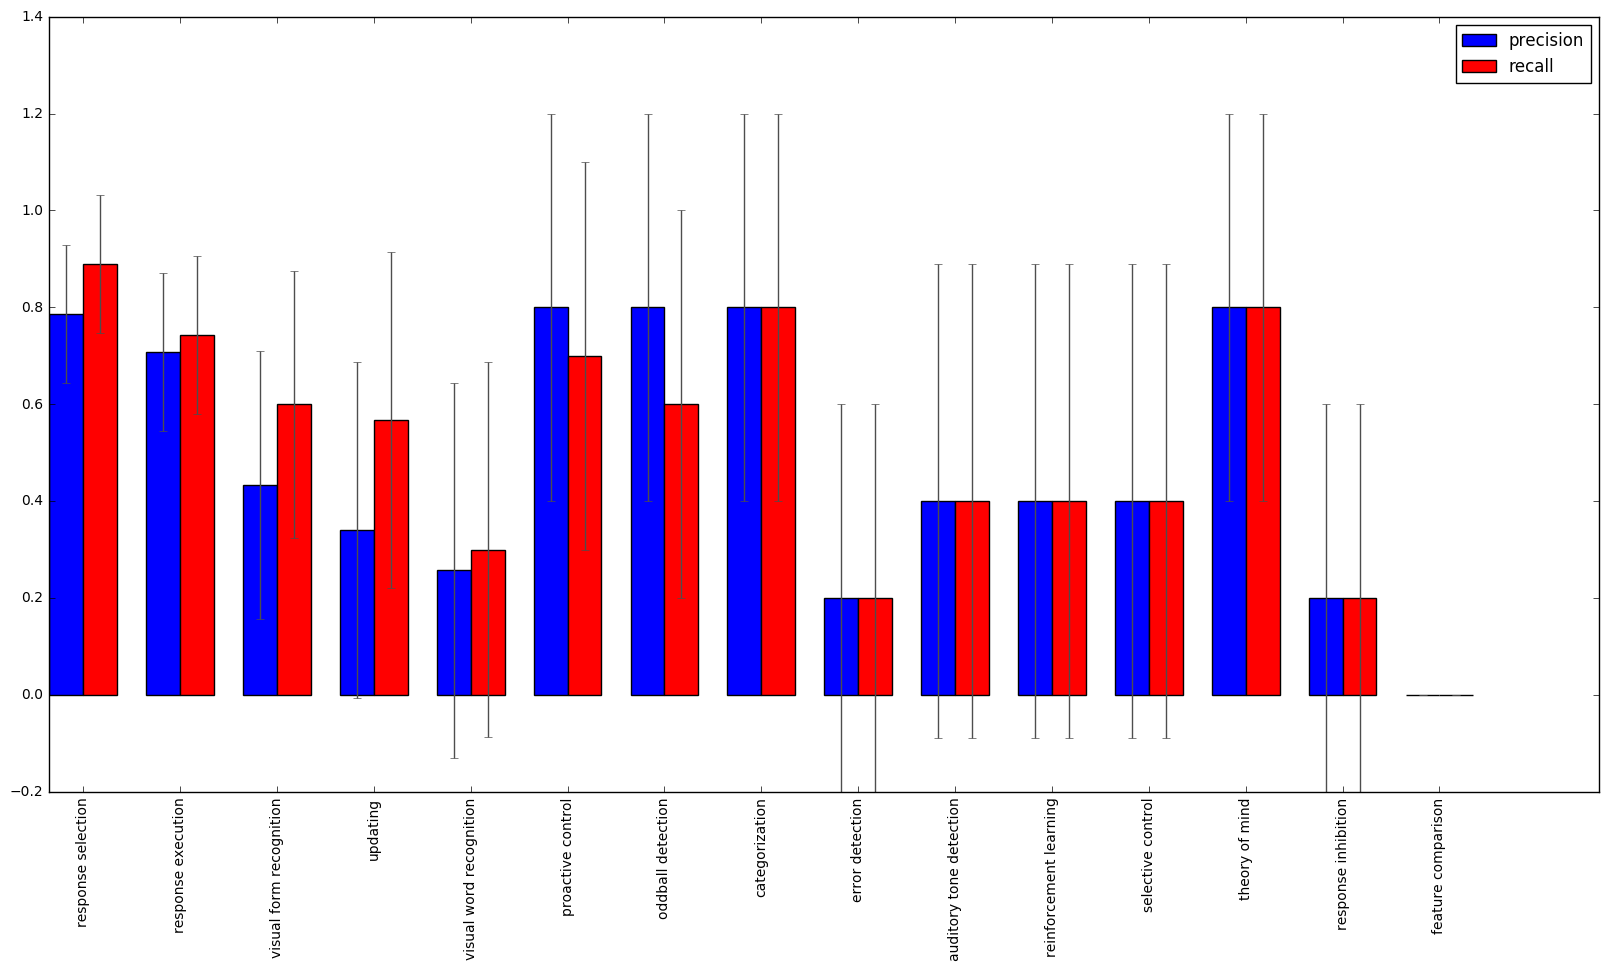

In [47]:

# print NBResults

precisions = []
recalls = []
precisionsVar = []
recallsVar = []
totalCount = []

for concept in concepts:
    result = NBResults[concept]
    totalCount.append(result[2])
    
order = np.argsort(totalCount).tolist()
order.reverse()


counter = 0

names = []
for idx in order:
    counter += 1
    if counter == 16:
        break
    concept = concepts[idx]
    names.append(concept)
    result = NBResults[concept]
    precisions.append(np.mean(result[0]))
    recalls.append(np.mean(result[1]))
    precisionsVar.append(np.std(result[0]))
    recallsVar.append(np.std(result[1]))
    
#     if (result[(1,1)]+result[(1,0)]) == 0:
#         precisions.append(0)
#     else: 
#         precisions.append(float(result[(1,1)]) / (result[(1,1)]+result[(1,0)]))
#     if (result[(1,1)]+result[(0,1)]) == 0:
#         recalls.append(0)
#     else:
#         recalls.append(float(result[(1,1)]) / (result[(1,1)]+result[(0,1)]))
    

real_names = getNames(names)
error_config = {'ecolor': '0.3'}
bar_width = 0.35
plt.figure(figsize=(20,10))
plt.bar(np.arange(len(precisions)),precisions, bar_width, yerr = precisionsVar, error_kw=error_config, color = 'b', label = 'precision')
plt.bar(np.arange(len(precisions)) + bar_width, recalls, bar_width, yerr = precisionsVar, error_kw=error_config, color = 'r', label = 'recall')
# print names[0]
plt.xticks(np.arange(len(precisions)) + bar_width, real_names, rotation = 'vertical')

plt.legend()
plt.show()

## counts by label

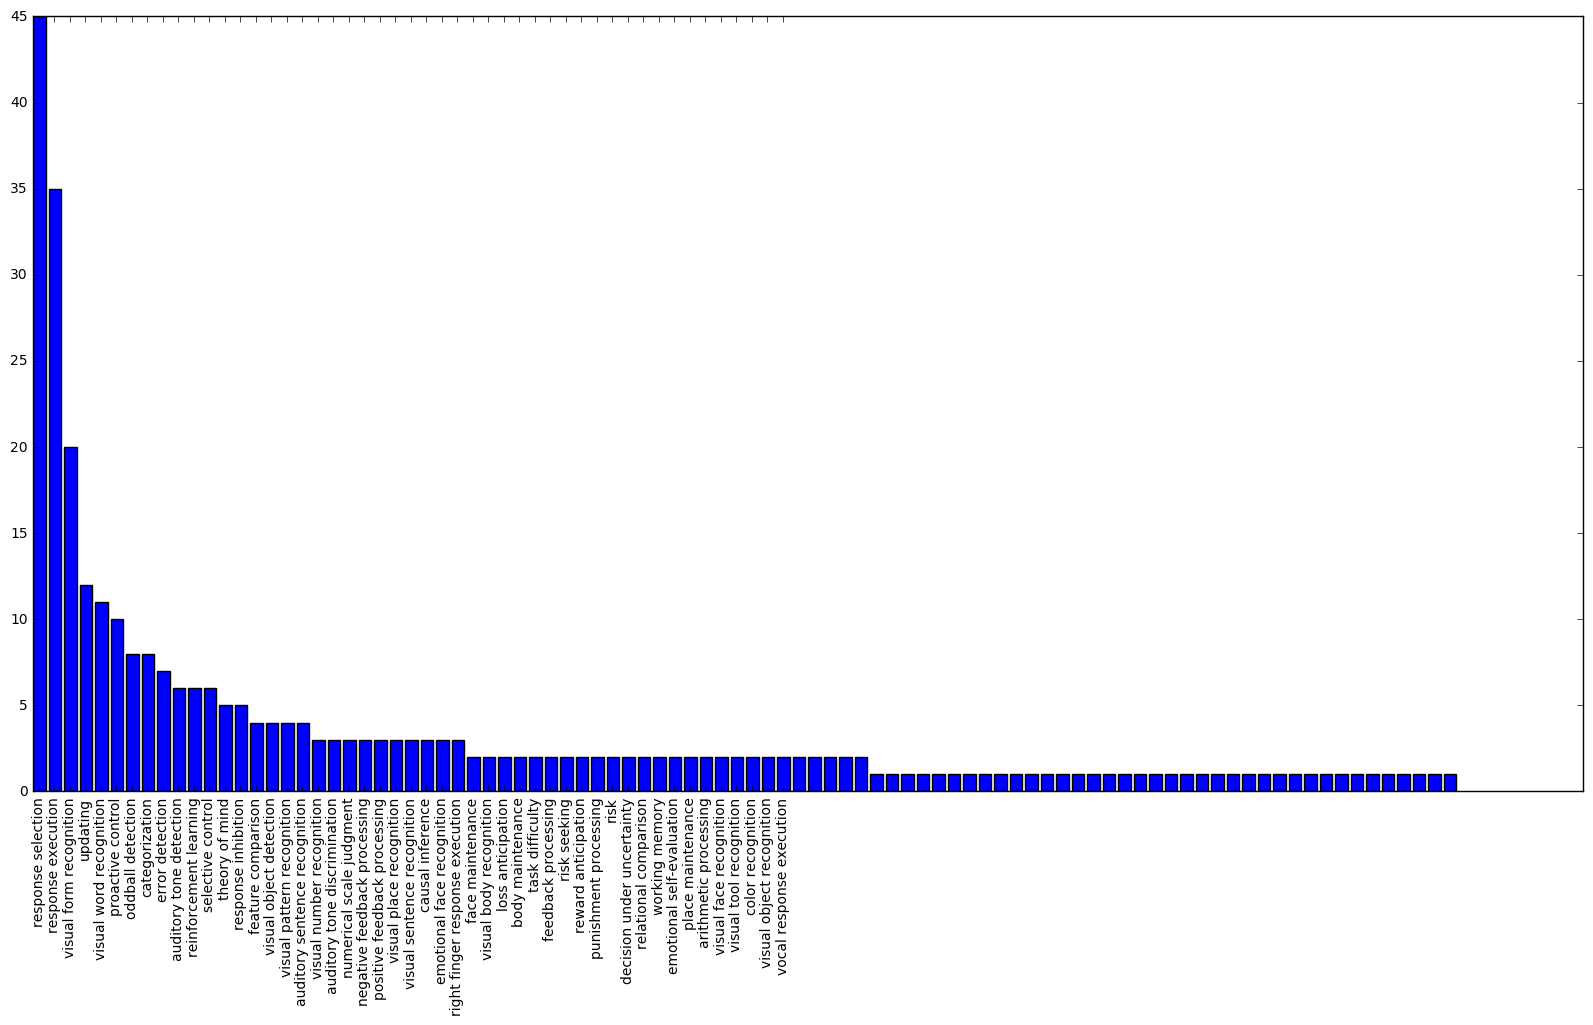

In [83]:
totalCounts = countPos(y)

names = []
for idx in order:
    names.append(concepts[idx])

totalCount = []
counter = 0
for idx in order:
    counter += 1
#     if counter == :
#         break
    concept = concepts[idx]
    totalCount.append(totalCounts[idx])
plt.figure(figsize=(20,10))
plt.bar(np.arange(len(totalCount)), totalCount)
plt.xticks(np.arange(len(precisions)) + bar_width, real_names, rotation = 'vertical')

plt.show()

# Iterative Stratification

In [185]:

def get_argmin_exclude_zero(num_pos_y_remaining):
    argmin = -1
    min_val = max(num_pos_y_remaining) + 1
    ties = []
    for i in range(len(num_pos_y_remaining)):
        if num_pos_y_remaining[i] <= min_val and num_pos_y_remaining[i] != 0:
            if num_pos_y_remaining[i] == min_val:
                ties.append(i)
            else:
                ties = []
                argmin = i
                min_val = num_pos_y_remaining[i]
    ties.append(argmin)
    return np.random.choice(ties)

def get_subset(c_l, c_j):
    #get max
    argmax = -1
    max_val = -1
    ties = []
    for i in range(len(c_l)):
        if c_l[i] == max_val:
            ties.append(i)
        elif c_l[i] > max_val:
            ties = []
            argmax = i
            max_val = c_l[i]
    ties.append(argmax)
    
    if len(ties) == 1:
        return ties[0]
    else:
        #go by c_j
        argmax = -1
        max_val = -1
        ties = []
        for i in range(len(c_j)):
            if c_j[i] == max_val:
                ties.append(i)
            elif c_j[i] > max_val:
                ties = []
                argmax = i
                max_val = c_j[i]
        ties.append(argmax)
        return np.random.choice(ties)
    
   
#do we even need X?
#k: the number of folds
def iterative_stratification(X, y, k):
    np.random.seed(1)
    num_examples = y.shape[0]
    num_labels = y.shape[1]
    D = range(num_examples)
    r = 1/float(k)
    c_j = np.empty(k) 
    c_j.fill(len(D) * r) #the number of desired examples per fold. 
    D_i = np.sum(y, axis = 0)
    c_i_j = np.outer(np.ones(k) * r, D_i) #(k, num_labels)) #breakdown the number of desired examples by label
    
    S = []
    for i in range(k):
        S.append([])

    lmins = []
    while len(D) > 0:
        D_i = np.sum(y[D, :], axis = 0)
        l = get_argmin_exclude_zero(D_i)
        if l == -1: #no labels left? (possible if one ex gets no label?)
            print len(D) , " left, assigning randomly now"
            for elem in D:
                m = np.random.choice(range(k))
                S[m].append(elem)
            break
            
        lmins.append(l)
        removedIndices = set()
        for idx in D:
            if y[idx, l] == 1:
                m = get_subset(c_i_j[:, l], c_j)
#                 print c_i_j
#                 print m
                S[m].append(idx)
                removedIndices.add(idx)
                c_i_j[m, np.where(y[idx, :] == 1)] -= 1
                c_j[m] -= 1
        for item in list(D):
            if item in removedIndices:
                D.remove(item)
        
    print len(lmins)
    
    
    train_test_splits = []
    for i in range(k):
        train = []
        for j in range(k):
            if j != i:
                train.extend(S[j])
        train_test_splits.append((train, S[i]))
    
    
    
    return train_test_splits
        
        
    
    

In [212]:
def evaluate_split(y, split):
#     print split
    for s in split:
        
        print np.sum(y[s[1]], axis = 0)[order]

In [219]:
test = iterative_stratification(X,y[:, order[:20]], 5)
# test = skf.split(X, y)
print y.shape
evaluate_split(y, test)
# for x in test:
#     print len(x[0]), len(x[1])

23  left, assigning randomly now
20
(93, 92)
[8 5 3 2 2 2 2 1 1 2 1 2 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1
 0 0 1 0 1 0 0 0 0 0 1 1 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
[8 5 3 2 3 1 2 1 3 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 2 0 0 1 0 0 0 0 1 0
 1 0 0 1 0 0 1 0 0 1 1 0 2 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[10  8  6  4  2  3  1  2  1  1  2  1  1  1  0  1  1  0  1  1  0  2  1  0  0
  1  1  0  0  0  0  0  0  0  1  0  0  0  1  1  1  0  0  0  0  2  0  0  0  0
  0  2  1  1  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  1  1  1  0  1  0  0  0]
[10  9  4  2  2  3  1  2  1  1  1  2  1  1  1  1  0  1  0  1  1  0  1  1  0
  0  1  0  1  0  0  0  0  1  0  0  0  0  0  0  0  1  1  1  1  0  0  0  1  0
  0  0  0  1  0  0  0  1  1  0  0  0  0  0  0  0  0  0  1  1  1  0  0  1  0
  0  0  0  1  0  0  0  1  0  0  0  0  0  0  1  0  0]
[9 8 4 2 2 1 2 2 

In [85]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, KFold

skf = KFold(n_splits=5)

X = norm.values # 
y = Y.values # example x concepts




# print y
pResults = []
rResults = []

numPos = countPos(y)
order = np.argsort(np.array(numPos)).tolist()
order.reverse()

counter = 0
# for idx in order:
#     counter += 1
#     print counter
for train_idx, test_idx in skf.split(X,y):

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    plsr = PLSRegression(n_components=2, scale=True)
    plsr.fit(X_train, y_train)
    preds = plsr.predict(X_test)
    print preds.shape
    y_preds = np.where(preds > 0.5, 1, 0)

    p, r = evaluate(y_preds, y_test)
    pResults.append(p)
    rResults.append(r)
pResults = np.vstack(pResults)
rResults = np.vstack(rResults)

# order

(19, 92)
(19, 92)
(19, 92)
(18, 92)
(18, 92)


(5, 92)


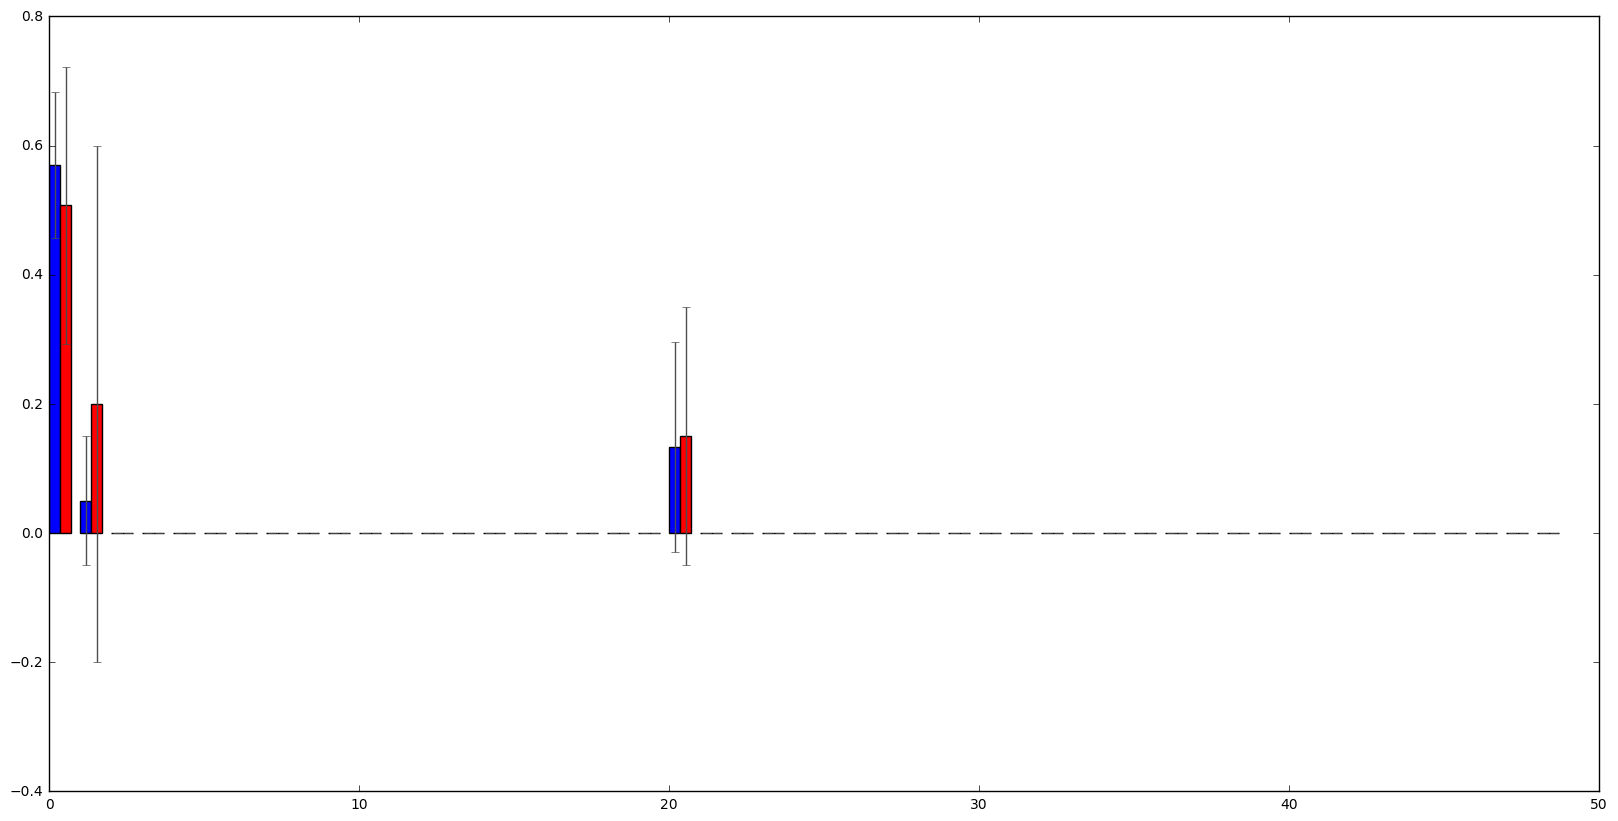

In [227]:
def plotResults(pResults, rResults, order):
    names = []
    precisions = []
    recalls = []
    precisionsVar= []
    recallsVar = []
    counter = 0
    print pResults.shape
    for idx in order:
        counter += 1
        if counter == 50:
            break
        concept = concepts[idx]
        names.append(concept)
        precisions.append(np.mean(pResults[:, idx]))
        recalls.append(np.mean(rResults[:, idx]))
        precisionsVar.append(np.std(pResults[:, idx]))
        recallsVar.append(np.std(rResults[:, idx]))
    # print pResults
    # print len(precisions)
    error_config = {'ecolor': '0.3'}
    bar_width = 0.35
    plt.figure(figsize=(20,10))
#     real_names = getNames(names)
#     plt.xticks(np.arange(len(precisions)) + bar_width, real_names, rotation = 'vertical')

    plt.bar(np.arange(len(precisions)),precisions, bar_width, yerr = precisionsVar, error_kw=error_config, color = 'b', label = 'precision')
    plt.bar(np.arange(len(precisions)) + bar_width, recalls, bar_width, yerr = recallsVar, error_kw=error_config, color = 'r', label = 'recall')
    plt.show()
plotResults(pResults, rResults, order)

In [22]:
1748/92

19

In [57]:
126. / (126 + 194)

0.39375

In [32]:
from cognitiveatlas.api import get_concept

a = get_concept(id=concepts[0]).json
a[0]['name']

http://cognitiveatlas.org/api/v-alpha/concept?id=trm_4a3fd79d0af71
Result Includes:<pandas:data frame><json:dict><txt:str><url:str>


u'response selection'